# What makes the Universe?


## Estimating few Cosmology parameters

We see this question on the walls of KIP 227, Heidelberg, its time to try to answer it. We can see that for large z, the linearity is reached only asymptotically as z decreases. This implies that expansion of the Universe is accelerating. If it was only composed of matter then, it would have positive decceleration parameter. That is, with only known matter component of the Universe we cannot have accelerated expansion. In the following we shall try to know what the Universe is composed of apart from matter. 

The acceleration is theoretically modelled using 'Dark Energy'. The easiest, simple, elegant and widely accepeted candidate for Dark Energy is the Cosmological Constant (there are very fundamental issues with this or any other candidate for DE - see the notes for 'Open Problems in Cosmology'). 

In the lectures or in the notes, you have derived an expression for distance in terms of Hubble Parameter. From this expression, we have following parameters to estimate from the data,

h- dimensionless Hubble parameter

$\Omega_m$ - density fraction of matter

$\Omega_{de}$ - density fraction of unknown dark energy

We can use the same data from Supernova Cosmology Project http://supernova.lbl.gov/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

Here we can use apparaent magnitude as the y-axis and leave redshift in the x-axis. 

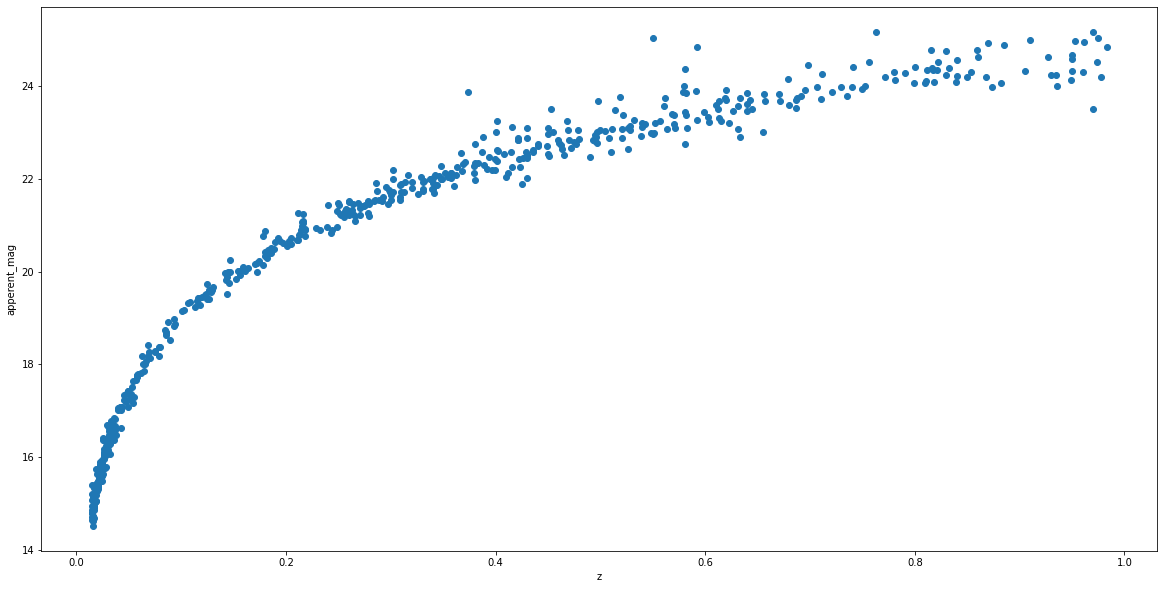

In [3]:
file1 = open('sn.txt', 'r')
Lines = file1.readlines()
 
z = []
distance_mod = []
# Strips the newline character
for line in Lines:
    x = line.split()
    if float(x[1]) < 1:
        z.append(float(x[1]))
        distance_mod.append(float(x[2]))
        
z = np.array(z)
distance_mod = np.array(distance_mod)

c = 3 * 1e5
apperent_mag = distance_mod - 19.3081547178

plt.scatter(z, apperent_mag)
plt.xlabel('z')
plt.ylabel('apperent_mag')
plt.show()

'a', is just an initial condition

In [4]:
def model(theta,z=z):
    m, de, dm, h, a = theta
    q = 1 - (2 * de * (h**2)) - (0.5 * dm * (h**2))
    return np.log(m * z * (1 + (0.5 * (1 - q) * z)) * c) + a

In [5]:
def lnprior(theta):
    m, de, dm, h, a = theta
    if 0.01 < m < 0.016 and de + dm <= 1 and 0.0 <= de < 1.0 and 0.0 <= dm < 1.0  and 0.6 < h < 0.8: 
        return 0.0
    return -np.inf

In [6]:
def lnlike(theta, x, y, yerr):
    return - np.sqrt(0.5) * np.sum(((y - model(theta, x))/yerr) ** 2)

In [7]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + 1e-10 * lnlike(theta, x, y, yerr)

In [18]:
apperent_mag_err = 0.001 * np.mean(apperent_mag)
data = (z, apperent_mag,apperent_mag_err)
nwalkers = 128
niter = 500
initial = np.array([0.0125, 0, 0.6, 0.7, 14])
ndim = len(initial)
p0 = [np.array(initial) + 1e-10 * np.random.randn(ndim) for i in range(nwalkers)]

Here, we have set the the unknow energy density of 'Dark Energy'(CC) to be 0 initially. Later we see that the data tells us that, this component is actually dominant than the matter.  

In [19]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 10)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [20]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


C:\Users\osama\anaconda3\envs\MCMC\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Running production...


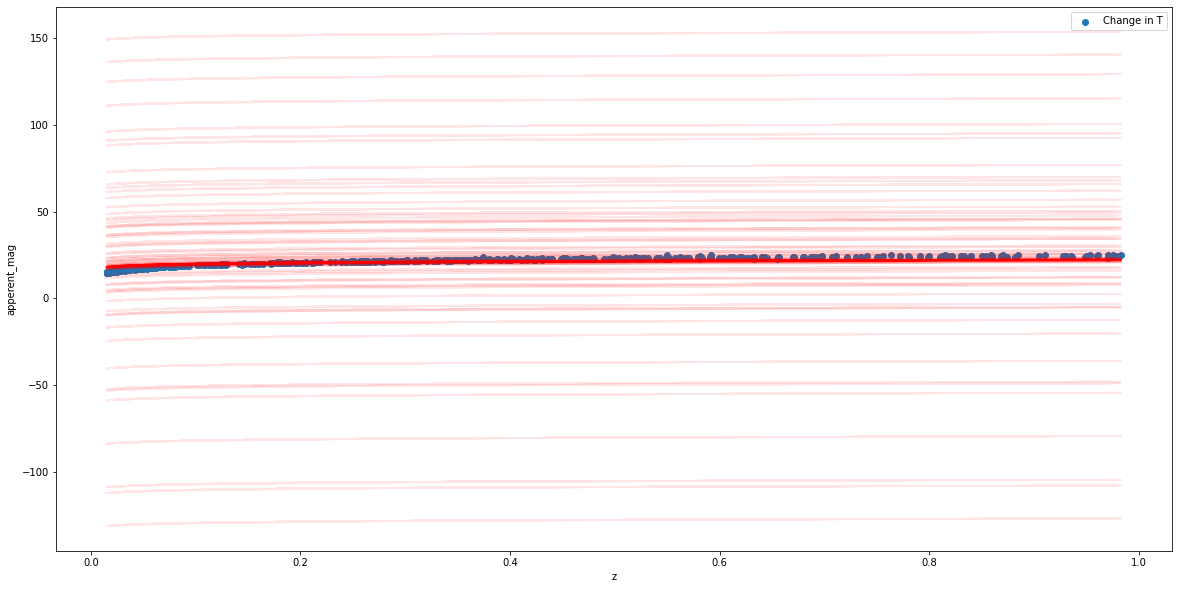

In [21]:
def plotter(sampler,z=z,apperent_mag=apperent_mag):
    plt.ion()
    plt.scatter(z,apperent_mag,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(z, model(theta, z), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('z')
    plt.ylabel('apperent_mag')
    plt.legend()
    plt.show()

plotter(sampler)

We see that, we get a better estimation for current Hubble parameter than the previous exercise. It shows that, the recent Universe, is dominated with Dark Energy, which is accelerating the expansion of the Universe.  

In [22]:
samples = sampler.flatchain
best = samples[np.argmax(sampler.flatlnprobability)]
print(best)

[1.23919204e-02 6.84561016e-01 1.86606429e-01 7.91330961e-01
 1.38390423e+01]


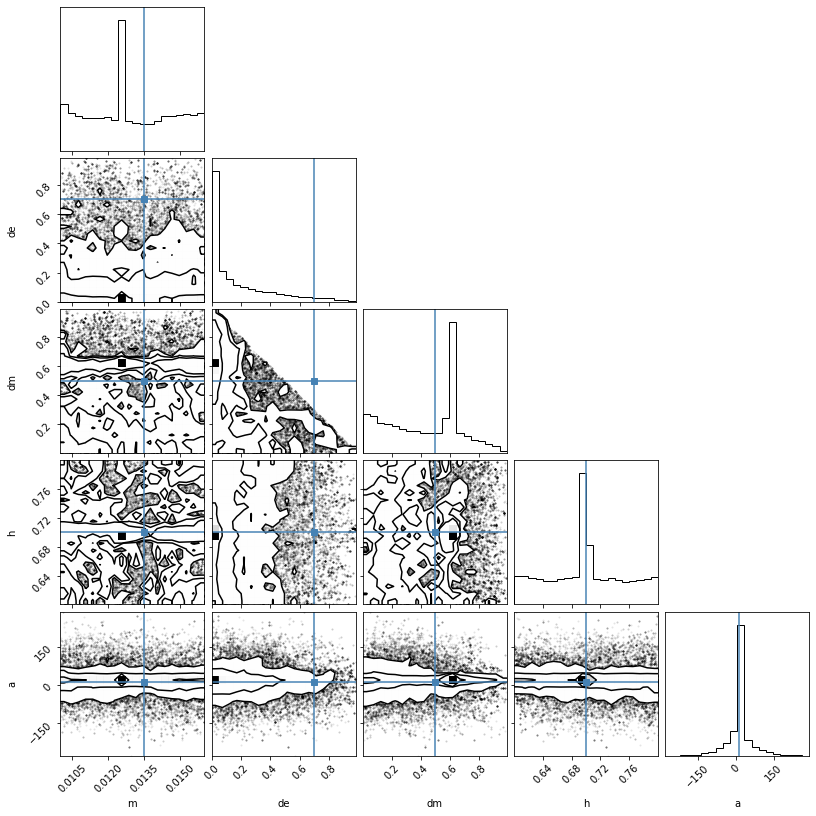

In [23]:
labels = ["m","de", "dm", "h",'a']
fig = corner.corner(
    samples, labels=labels, truths=[0.0135, 0.7, 0.5, 0.7, 14]
);